# Testing Multivariate Structure Models to Determine Node Causal Parents

In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.models.causal_parent_multivariate_model import *
from cs330.models.full_causal_graph_multivariate_model import *
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

In [3]:
# Training Constants
N = 10
M = 3
inner_lr = 1e-3
outer_lr = 1e-2
transfer_episode_count = 200
transfer_episode_gradient_steps = 20
transfer_episode_batch_size = 500
pretrain_episode_gradient_steps = 200
pretrain_episode_batch_size = 1000

hypothesis_sample_count = 20 # Number of hypotheses to sample for each structure update

In [4]:
'''
Create a causal parent multivariate model for the target node and data generator (including graph),
learn causal structure, and plot a graph of structure adaptation for each possible parent node.

Returns training curve log (runs, transfer episodes, target node, parent node), where each element is a likelihood
for parent node to cause target node.
Also returns the final predicted graphs after each run
'''
def full_graph_structure_training(data_gen, num_runs=1, savename="", model_type=CausalParentMultivariateModel):
    # Create model
    model = model_type(N, M, hypothesis_sample_count)
    hypothesis_opt = torch.optim.SGD(model.hypothesis_parameters(), lr=inner_lr)
    structure_opt = torch.optim.RMSprop(model.structure_parameters(), lr=outer_lr)

    # Store structure training logs
    structure_likelihood_logs = torch.zeros(num_runs, transfer_episode_count + 1, *model.structure_likelihoods().shape).detach()
    # Store full-graph predictions at the end of each run
    graph_predictions = torch.zeros(num_runs, M, M)

    for i in tnrange(num_runs, leave=False):
        # Sample a new distribution
        data_gen.reset_all_distributions()

        # Reset structure parameters
        model.reset_structure_parameters()

        # Log initial parent likelihoods
        structure_likelihood_logs[i, 0] = model.structure_likelihoods()

        # Pretrain model on base distribution
        # (Assume hypothesis where all other nodes are causal parents)
        pretrain_hypotheses = model.pretrain_hypotheses()
        for hypothesis_iter in tnrange(len(pretrain_hypotheses), leave=False):
            pretrain_hypothesis = pretrain_hypotheses[hypothesis_iter]
            
            for grad_step in tnrange(pretrain_episode_gradient_steps, leave=False):
                # Sample from pretrain distribution
                pretrain_samples = data_gen.sample(pretrain_episode_batch_size)
            
                hypothesis_opt.zero_grad()
                logL = model.hypothesis_log_likelihood(pretrain_hypothesis, pretrain_samples)
                loss = -torch.sum(logL) # Sum over loss for each target node, to train all at once
                loss.backward()
                hypothesis_opt.step()
            model.save_pretrained(pretrain_hypothesis)

        # Iterate through transfer episodes, updating structure params on each
        transfers = tnrange(transfer_episode_count, leave=False)
        for transfer_episode in transfers:
            # Sample a new transfer distribution (adjusting root node functions)
            data_gen.reset_root_distributions()

            # Iterate through sampled hypotheses
            hypothesis_list = model.sample_hypotheses()
            hypothesis_online_logL = torch.zeros(len(hypothesis_list), M).detach()
            for hypothesis_iter in range(len(hypothesis_list)):
                hypothesis = hypothesis_list[hypothesis_iter]

                # Accumulate log likelihood over training for this hypothesis
                online_logL = torch.zeros(M).detach()

                # Reset node function to pretrained state
                model.load_pretrained(hypothesis)

                # Train this hypothesis model
                for grad_step in range(transfer_episode_gradient_steps):
                    # Sample from transfer distribution
                    train_samples = data_gen.sample(transfer_episode_batch_size)

                    hypothesis_opt.zero_grad()
                    logL = model.hypothesis_log_likelihood(hypothesis, train_samples)
                    loss = -torch.sum(logL) # Sum over all target node losses to train all node functions at once
                    loss.backward()
                    hypothesis_opt.step()

                    # Accumulate online log likelihood for each target node with this hypothesis
                    online_logL += logL.detach()

                # Save results for this hypothesis
                hypothesis_online_logL[hypothesis_iter, :] = online_logL

            # Update structure parameters
            structure_opt.zero_grad()
            model.compute_structure_gradients(hypothesis_list, hypothesis_online_logL)
            structure_opt.step()

            # Log structure params
            current_structure_params = model.structure_likelihoods()
            structure_likelihood_logs[i, transfer_episode + 1] = current_structure_params

            # Add debug info to transfer episode progress bar
            transfers.set_postfix(structure=current_structure_params.tolist())

        # Store final graph prediction for this run after meta-training loop is complete
        graph_predictions[i] = model.predicted_graph()
        

    # Optional plotting of results
    if savename:
        # Plot Graph for visualization
        #data_gen.graph.visualize()
        #if savename:
            #plt.savefig(f"{savename}.graph.png")

        # Plot structure parameter training progress
        def plot_one_structure_likelihood_index(ax, logs, name):
            ax.title.set_text(name)
            for run in range(num_runs):
                ax.plot(logs[run, :].detach().numpy())

            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.axhline(1, c='lightgray', ls='--')
            ax.axhline(0, c='lightgray', ls='--')
            ax.set_xlim([0, transfer_episode_count])
            ax.set_xlabel('Number of episodes', fontsize=14)
            ax.set_ylabel("Hypothesis Likelihood", fontsize=14)

        structure_param_shape = model.structure_likelihoods().shape
        if len(structure_param_shape) == 2:
            rows, cols = structure_param_shape
            fig, axarr = plt.subplots(rows, cols, figsize=(4.5 * cols, 3 * rows), constrained_layout=True)
            for i in range(rows):
                for j in range(cols):
                    plot_one_structure_likelihood_index(axarr[i][j], structure_likelihood_logs[:, :, i, j], model.structure_param_name(i, j))
        elif len(structure_param_shape) == 1:
            rows = structure_param_shape[0]
            fig, axarr = plt.subplots(rows, 1, figsize=(4.5, 3 * rows), constrained_layout=True)
            for i in range(rows):
                plot_one_structure_likelihood_index(axarr[i], structure_likelihood_logs[:, :, i], model.structure_param_name(i))
        elif len(structure_param_shape) == 3:
            rows = np.prod(structure_param_shape[:-1])
            cols = structure_param_shape[-1]
            fig, axarr = plt.subplots(rows, cols, figsize=(4.5 * cols, 3 * rows), constrained_layout=True)
            for row in range(rows):
                for col in range(cols):
                    i, j = np.unravel_index(row, structure_param_shape[:-1])
                    channel = col
                    plot_one_structure_likelihood_index(axarr[row][col], structure_likelihood_logs[:, :, i, j, channel], model.structure_param_name(i, j, channel))
        else:
            raise ValueError(f"Cannot plot structure logs with structure param shape {structure_param_shape}")

        plt.suptitle(savename)
        plt.savefig(f"{savename}.training.png", facecolor='white', transparent=False)
        plt.show()

    return structure_likelihood_logs, graph_predictions

In [5]:
# Function for testing pairwise adaptation of binary transfer objective to multivariate case
def pairwise_structure_training(data_gen, num_runs=1, savename=""):
    # Save the list of hypotheses considered by the binary model
    hypothesis_list = CauseOnlyBinaryStructureModel(N, M, 0, 1).hypotheses()

    # Iterate through all node pairs and save resulting predicted structures
    node_pairs = []
    for A in range(M - 1):
        for B in range(A + 1, M):
            node_pairs.append((A, B))

    structure_predictions = {} # {NodePair -> {Hypothesis -> float}}
    structure_training_curves = {} # {NodePair -> {Hypothesis -> torch.FloatTensor(shape = (num_runs, transfer_episodes + 1))}}
    for i in tnrange(len(node_pairs)):
        A, B = node_pairs[i]

        # Average structure results over multiple runs (same graph, same causal edge functions, newly sampled root functions)
        node_pair_predictions = {hypothesis: 0.0 for hypothesis in hypothesis_list}
        node_pair_training_curves = {hypothesis: torch.zeros(num_runs, transfer_episode_count + 1).detach() for hypothesis in hypothesis_list}
        for run in tnrange(num_runs, leave=False):
            data_gen.reset_all_distributions() # Keeps the graph, but changes function parametrizing effect nodes by cause nodes

            model = CauseOnlyBinaryStructureModel(N, M, A, B)
            model_handler = AugmentedBinaryModelTrainer(
                data_gen, model,
                inner_lr = inner_lr,
                outer_lr = outer_lr,
                transfer_episode_count = transfer_episode_count,
                transfer_episode_gradient_steps = transfer_episode_gradient_steps,
                transfer_episode_batch_size = transfer_episode_batch_size,
                pretrain_episode_batch_size = pretrain_episode_batch_size
            )

            # Meta-learn structure
            model_handler.train_structure()

            # Save structure training curve
            for hyp_ind, hypothesis in enumerate(hypothesis_list):
                node_pair_training_curves[hypothesis][run, :] = model_handler.structure_likelihoods[:, hyp_ind]

            # Save final learned structure likelihood values
            for hypothesis, probability in zip(model.hypotheses(), model_handler.structure_likelihoods[-1].tolist()):
                node_pair_predictions[hypothesis] += probability / num_runs

        # Save resulting structure prediction
        structure_predictions[(A, B)] = node_pair_predictions
        structure_training_curves[(A, B)] = node_pair_training_curves

    # Plot Training curves for each hypothesis and node pair
    if savename:
        fig, axarr = plt.subplots(M, M, figsize=(4.5 * M, 3 * M), constrained_layout=True)
        fig.suptitle(savename)
        for A, B in node_pairs:
            # Graph A -> B
            ax = axarr[B][A]
            ax.title.set_text(f"Node {A} -> Node {B}")
            for run in range(num_runs):
                ax.plot(structure_training_curves[(A, B)][Hypothesis.FORWARD_CAUSE][run].numpy())
            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.axhline(1, c='lightgray', ls='--')
            ax.axhline(0, c='lightgray', ls='--')
            ax.set_xlim([0, transfer_episode_count])
            ax.set_xlabel('Number of episodes', fontsize=14)
            ax.set_ylabel("Hypothesis Likelihood", fontsize=14)

            # Graph B -> A
            ax = axarr[A][B]
            ax.title.set_text(f"Node {B} -> Node {A}")
            for run in range(num_runs):
                ax.plot(structure_training_curves[(A, B)][Hypothesis.BACKWARD_CAUSE][run].numpy())
            ax.tick_params(axis='both', which='major', labelsize=13)
            ax.axhline(1, c='lightgray', ls='--')
            ax.axhline(0, c='lightgray', ls='--')
            ax.set_xlim([0, transfer_episode_count])
            ax.set_xlabel('Number of episodes', fontsize=14)
            ax.set_ylabel("Hypothesis Likelihood", fontsize=14)

        plt.savefig(f"{savename}.training.png", facecolor='white', transparent=False)
        plt.show()

# Run specific test cases on each multivariate structure model

In [6]:
# Causal Graphs to test
# List of elements (node_count, name, graph)
data_tests = [
    (
        "2_node_independent",
        np.array([
            [0, 0],
            [0, 0]
        ])
    ),
    (
        "2_node_dependent",
        np.array([
            [0, 0],
            [1, 0]
        ])
    ),
    (
        "3_node_1_independent",
        np.array([
            [0, 0, 0],
            [1, 0, 0],
            [0, 0, 0]
        ])
    ),
    (
        "3_node_chain",
        np.array([
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0]
        ])
    ),
    (
        "3_node_collider",
        np.array([
            [0, 0, 0],
            [0, 0, 0],
            [1, 1, 0]
        ])
    ),
    (
        "3_node_confounder",
        np.array([
            [0, 0, 0],
            [1, 0, 0],
            [1, 0, 0]
        ])
    )
]

In [7]:
# Models to test
# List of elements (name, model_class)
# pairwise_binary_objective is a special case, with a different testing function
model_tests = [
    ("pairwise_binary_objective", None),
    ("causal_parent_sampling", CausalParentMultivariateModel),
    ("causal_parent_all_hypotheses", AllHypotheses_CausalParentMultivariateModel),
    ("edge_factored_full_causal_graph_all_hypotheses", AllHypotheses_IndependentEdgeFullCausalGraphMultivariateModel),
    ("full_causal_graph_all_hypotheses", AllHypotheses_FullCausalGraphMultivariateModel)
]

In [8]:
# Training Constants
num_runs = 10
N = 5
inner_lr = 1e-3
outer_lr = 1e-2
transfer_episode_count = 200
transfer_episode_gradient_steps = 20
transfer_episode_batch_size = 500
pretrain_episode_gradient_steps = 200
pretrain_episode_batch_size = 1000
hypothesis_sample_count = 20 # Number of hypotheses to sample for each structure update

Testing pairwise_binary_objective on 2_node_independent


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

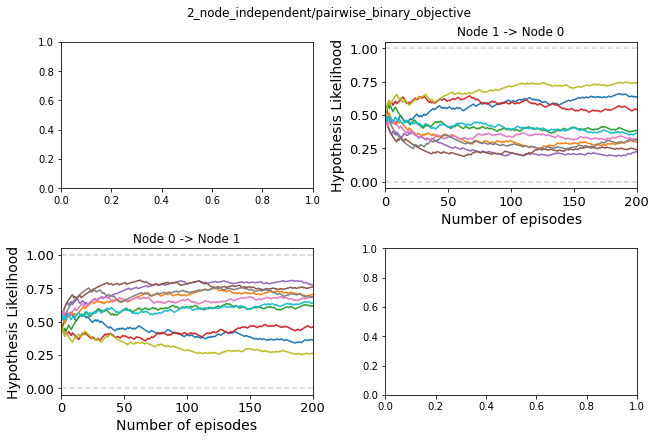

Testing pairwise_binary_objective on 2_node_dependent


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

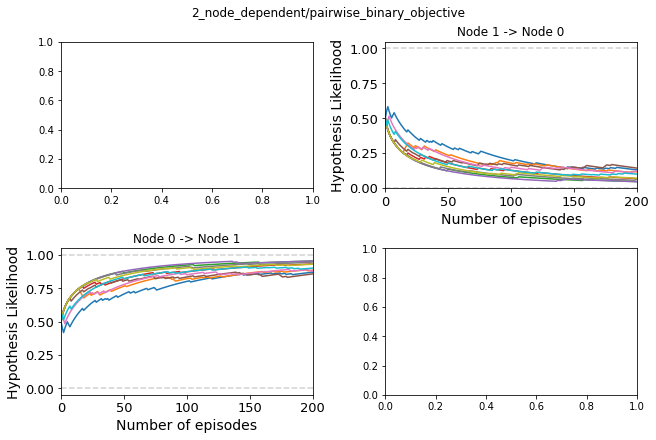

Testing pairwise_binary_objective on 3_node_1_independent


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

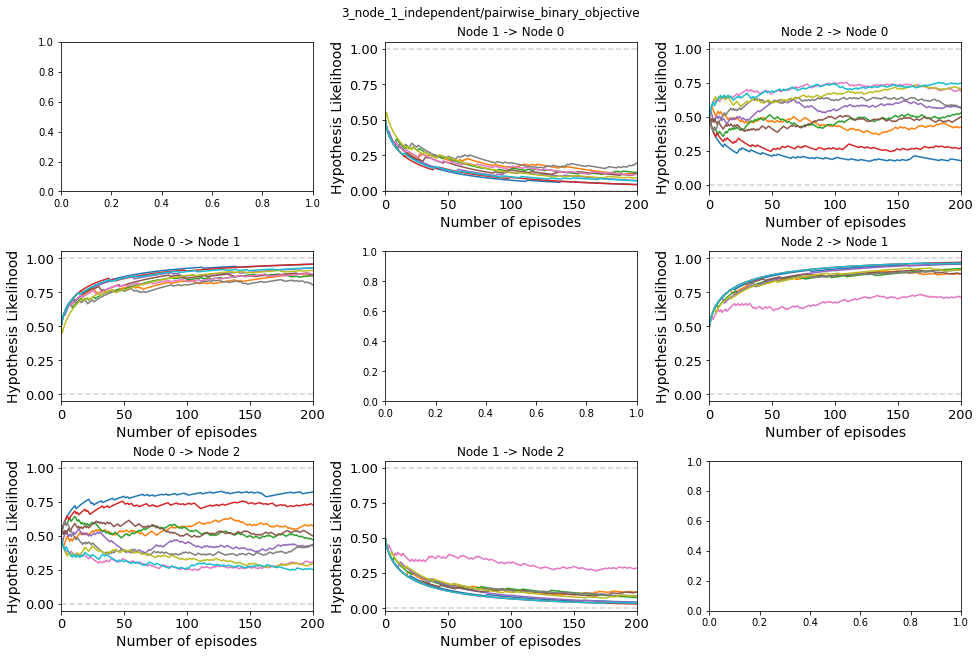

Testing pairwise_binary_objective on 3_node_chain


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

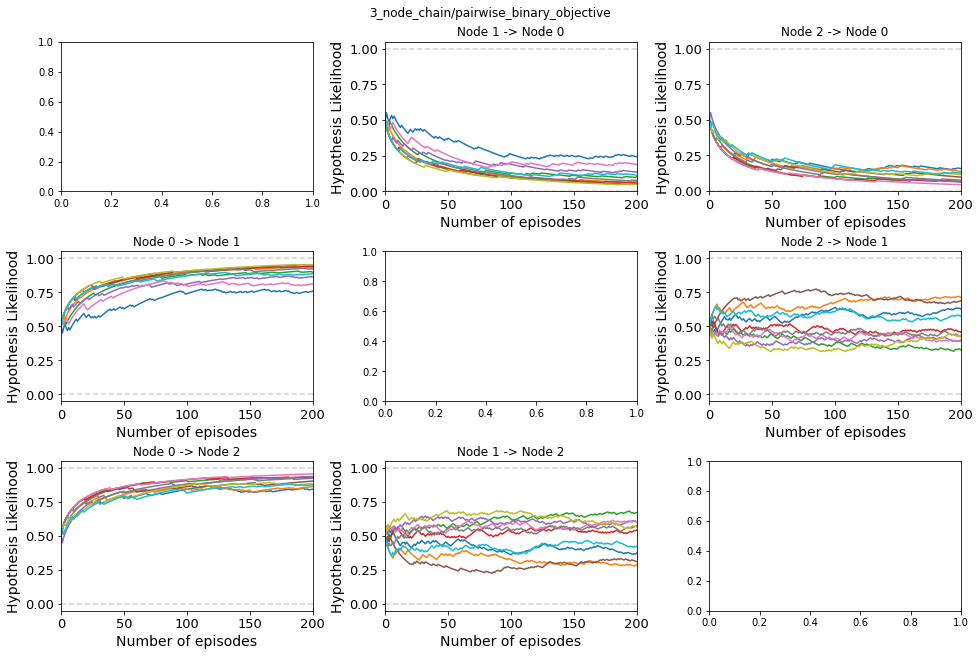

Testing pairwise_binary_objective on 3_node_collider


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

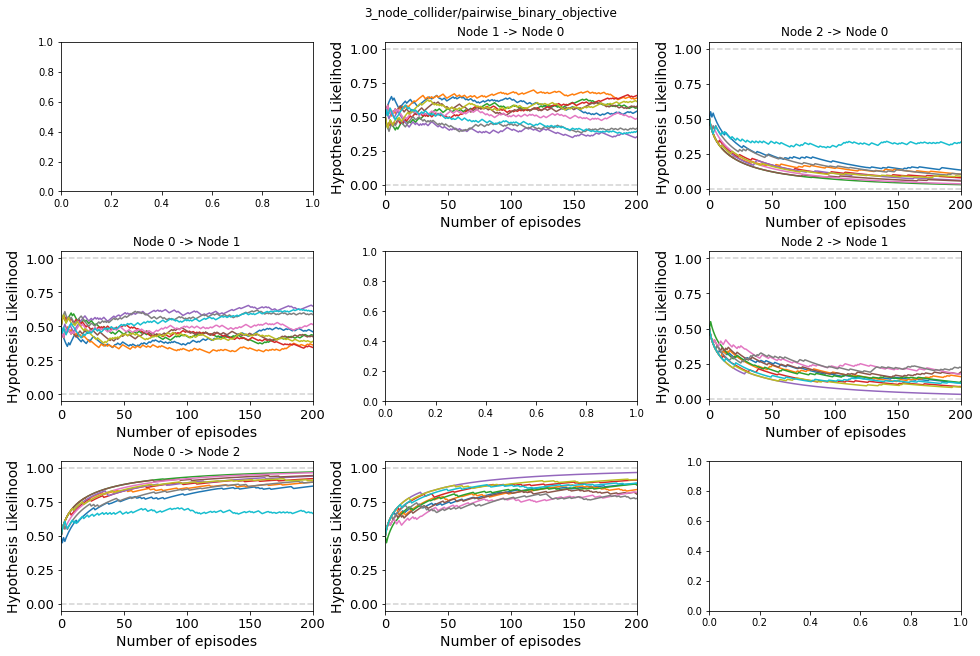

Testing pairwise_binary_objective on 3_node_confounder


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

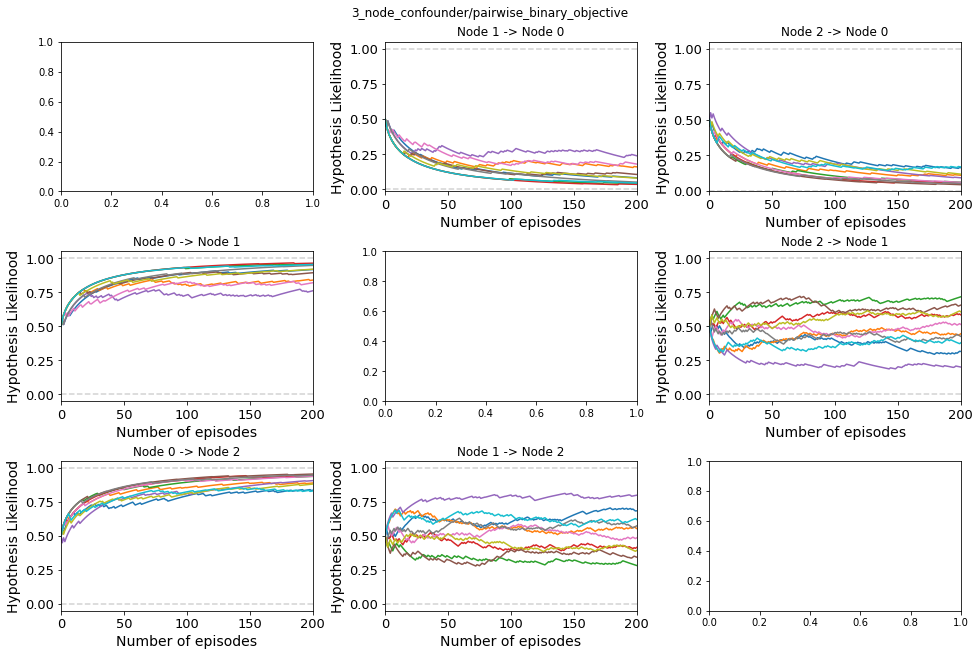

In [9]:
# Iterate through tests and models
for model_name, model_class in model_tests:
    for data_name, data_graph in data_tests:
        if not os.path.exists(data_name):
            os.mkdir(data_name)

        print(f"Testing {model_name} on {data_name}")

        M = len(data_graph)
        data_gen = MultiCategorical(N, M)
        data_gen.graph.B = np.array(data_graph)

        if model_name == "pairwise_binary_objective":
            pairwise_structure_training(data_gen, num_runs=num_runs, savename=f"{data_name}/{model_name}")
        else:
            full_graph_structure_training(data_gen, num_runs=num_runs, savename=f"{data_name}/{model_name}", model_type=model_class)